In [1]:
from qiskit import *
import qiskit.tools.jupyter
from qiskit.circuit.library import *
from qiskit.test.mock import *
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import math
import numpy as np
from qiskit.visualization import *
import matplotlib.pyplot as plt
from qiskit.visualization import array_to_latex
from qiskit.test.mock import *
TOKEN = "425efac7054b81d3ec8fd09588c29d8cf6a723ad23002782ef60fd0f48de27c90740f2be3da25bc513b1a9d0860fda0cf772b5953b035c9c5b4f41de1220dc4c"
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy, IBMQBackend

In [2]:
VECTOR_BACK = Aer.get_backend('statevector_simulator')
QASM_BACK = Aer.get_backend('qasm_simulator')

In [3]:
IBMQ.save_account(TOKEN)
IBMQ.load_account() 

def get_real_backend(nqbits):
    provider = IBMQ.get_provider(hub='ibm-q')
    small_providers = provider.backends(filters=lambda x: x.configuration().n_qubits >= nqbits
                                        and not x.configuration().simulator
                                        and x.status().operational==True)
    return least_busy(small_providers)

configrc.store_credentials:WARNING:2022-11-07 11:40:50,787: Credentials already present. Set overwrite=True to overwrite.


In [4]:
def myqft(n, barrier=False, initv=None):
    qc = QuantumCircuit(n)
    
    if initv is not None:
        qc.initialize(initv)
        qc.barrier()
        
    for i in reversed(range(n)):
        qc.h(i)
        for j in reversed(range(i)):
            angle = np.pi / (2**(i-j))
            qc.cp(angle, i, j)
        if barrier:
            qc.barrier()
            
    for i in range(n//2):
        qc.swap(i, n-i-1)
    return qc

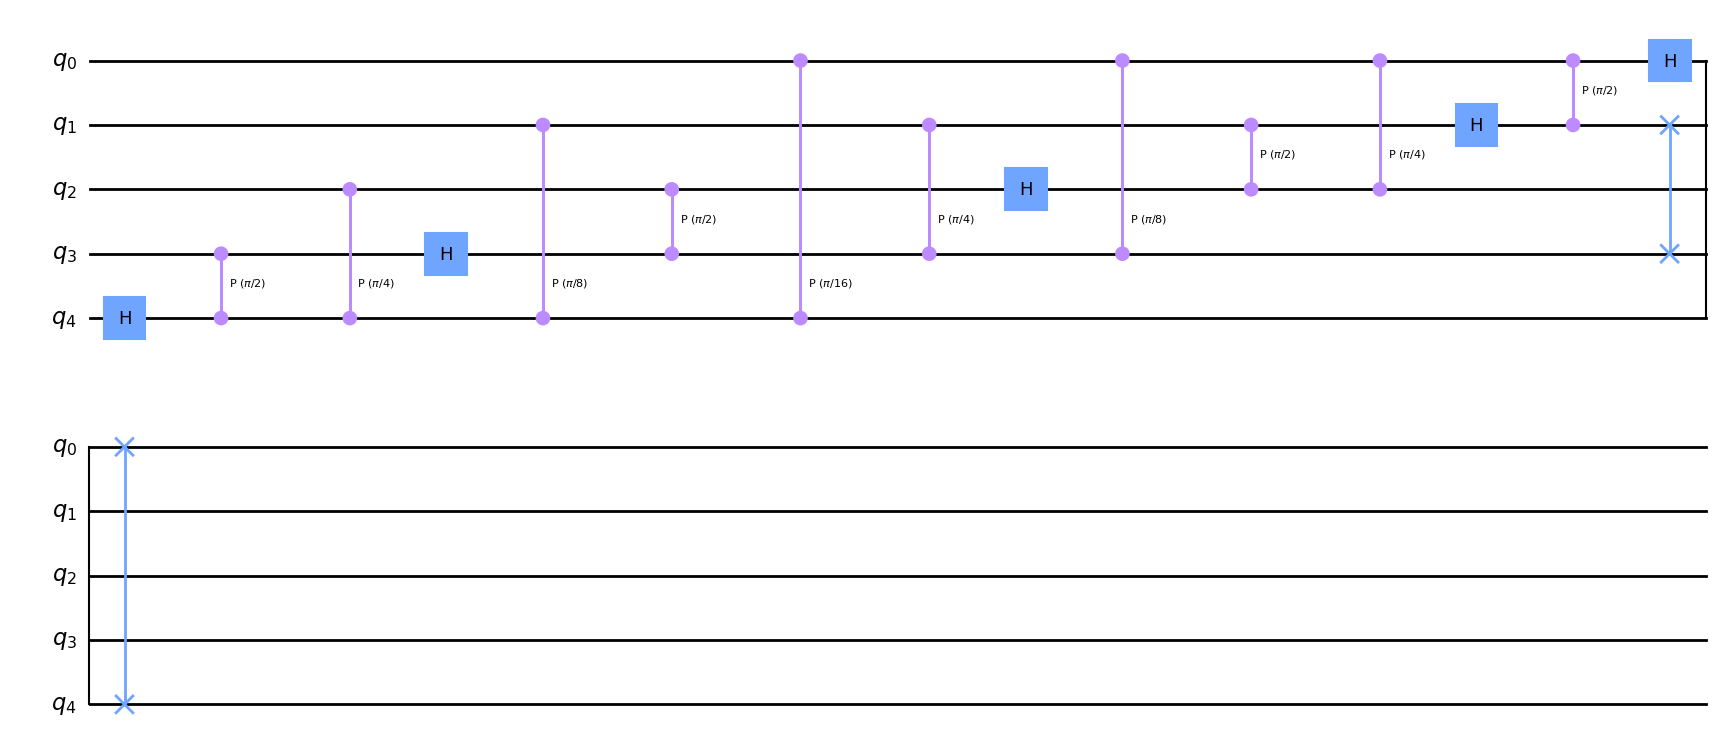

In [5]:
qc = myqft(5)
qc.draw(output='mpl')

In [6]:

def myqft2(nbtis, barrier=False, initv=None):
    circuit = QuantumCircuit(nbits)
    
    if initv is not None:
        circuit.initialize(initv)
        circuit.barrier()

    for j in reversed(range(nbits)):
        circuit.h(j)
        for k in reversed(range(j)):
            lam = np.pi / (2 ** (j - k))
            circuit.cp(lam, j, k)
        if barrier:
            circuit.barrier()

    for i in range(nbits // 2):
        circuit.swap(i, nbits - i - 1)
    return circuit


In [7]:
def myqft3(nbtis, barrier=False, initv=None):
    circuit = QuantumCircuit(nbits)
    
    if initv is not None:
        circuit.initialize(initv)
        circuit.barrier()

    for j in reversed(range(nbits)):
        circuit.h(j)
        for k in reversed(range(j)):
            lam = np.pi / (2 ** (j - k))
            circuit.crz(lam, k, j)
        if barrier:
            circuit.barrier()

    for i in range(nbits // 2):
        circuit.swap(i, nbits - i - 1)
    return circuit


In [6]:
def decimal_base2(rep: str) -> float:
    res = 0
    pot = 1
    for c in rep[::-1]:
        res = float(c)+res*0.5
    return res*0.5


In [7]:
decimal_base2('10')

0.5

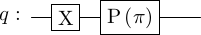

In [8]:
qc = QuantumCircuit(1)
qc.x(0)
qc.p(2*np.pi*decimal_base2('10'), 0)
qc.draw(output='latex')

In [ ]:
phi = execute(qc, VECTOR_BACK).result().get_statevector()
array_to_latex(phi)

In [11]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)


In [9]:
def mtrule2(qft, value='100'):
    nbits = len(value)
    gate = PhaseGate(2*np.pi*decimal_base2(value))
    qest = QuantumRegister(nbits, 'est')
    psi = QuantumRegister(1, 'psi')
    cres = ClassicalRegister(nbits, 'res')
    qc = QuantumCircuit(qest, psi, cres)
    qc.h(qest)
    qc.x(psi[:])
    power = 1
    for i in range(nbits):
        for j in range(power):
            qc.append(gate.control(), [i] + psi[:])
        #qc.append(gate.power(power).control(), [i] + psi[:])    
        power = 2*power
    qc.append(qft.inverse(), qest[:])
    qc.measure(qest[:], cres[:])
    return qc

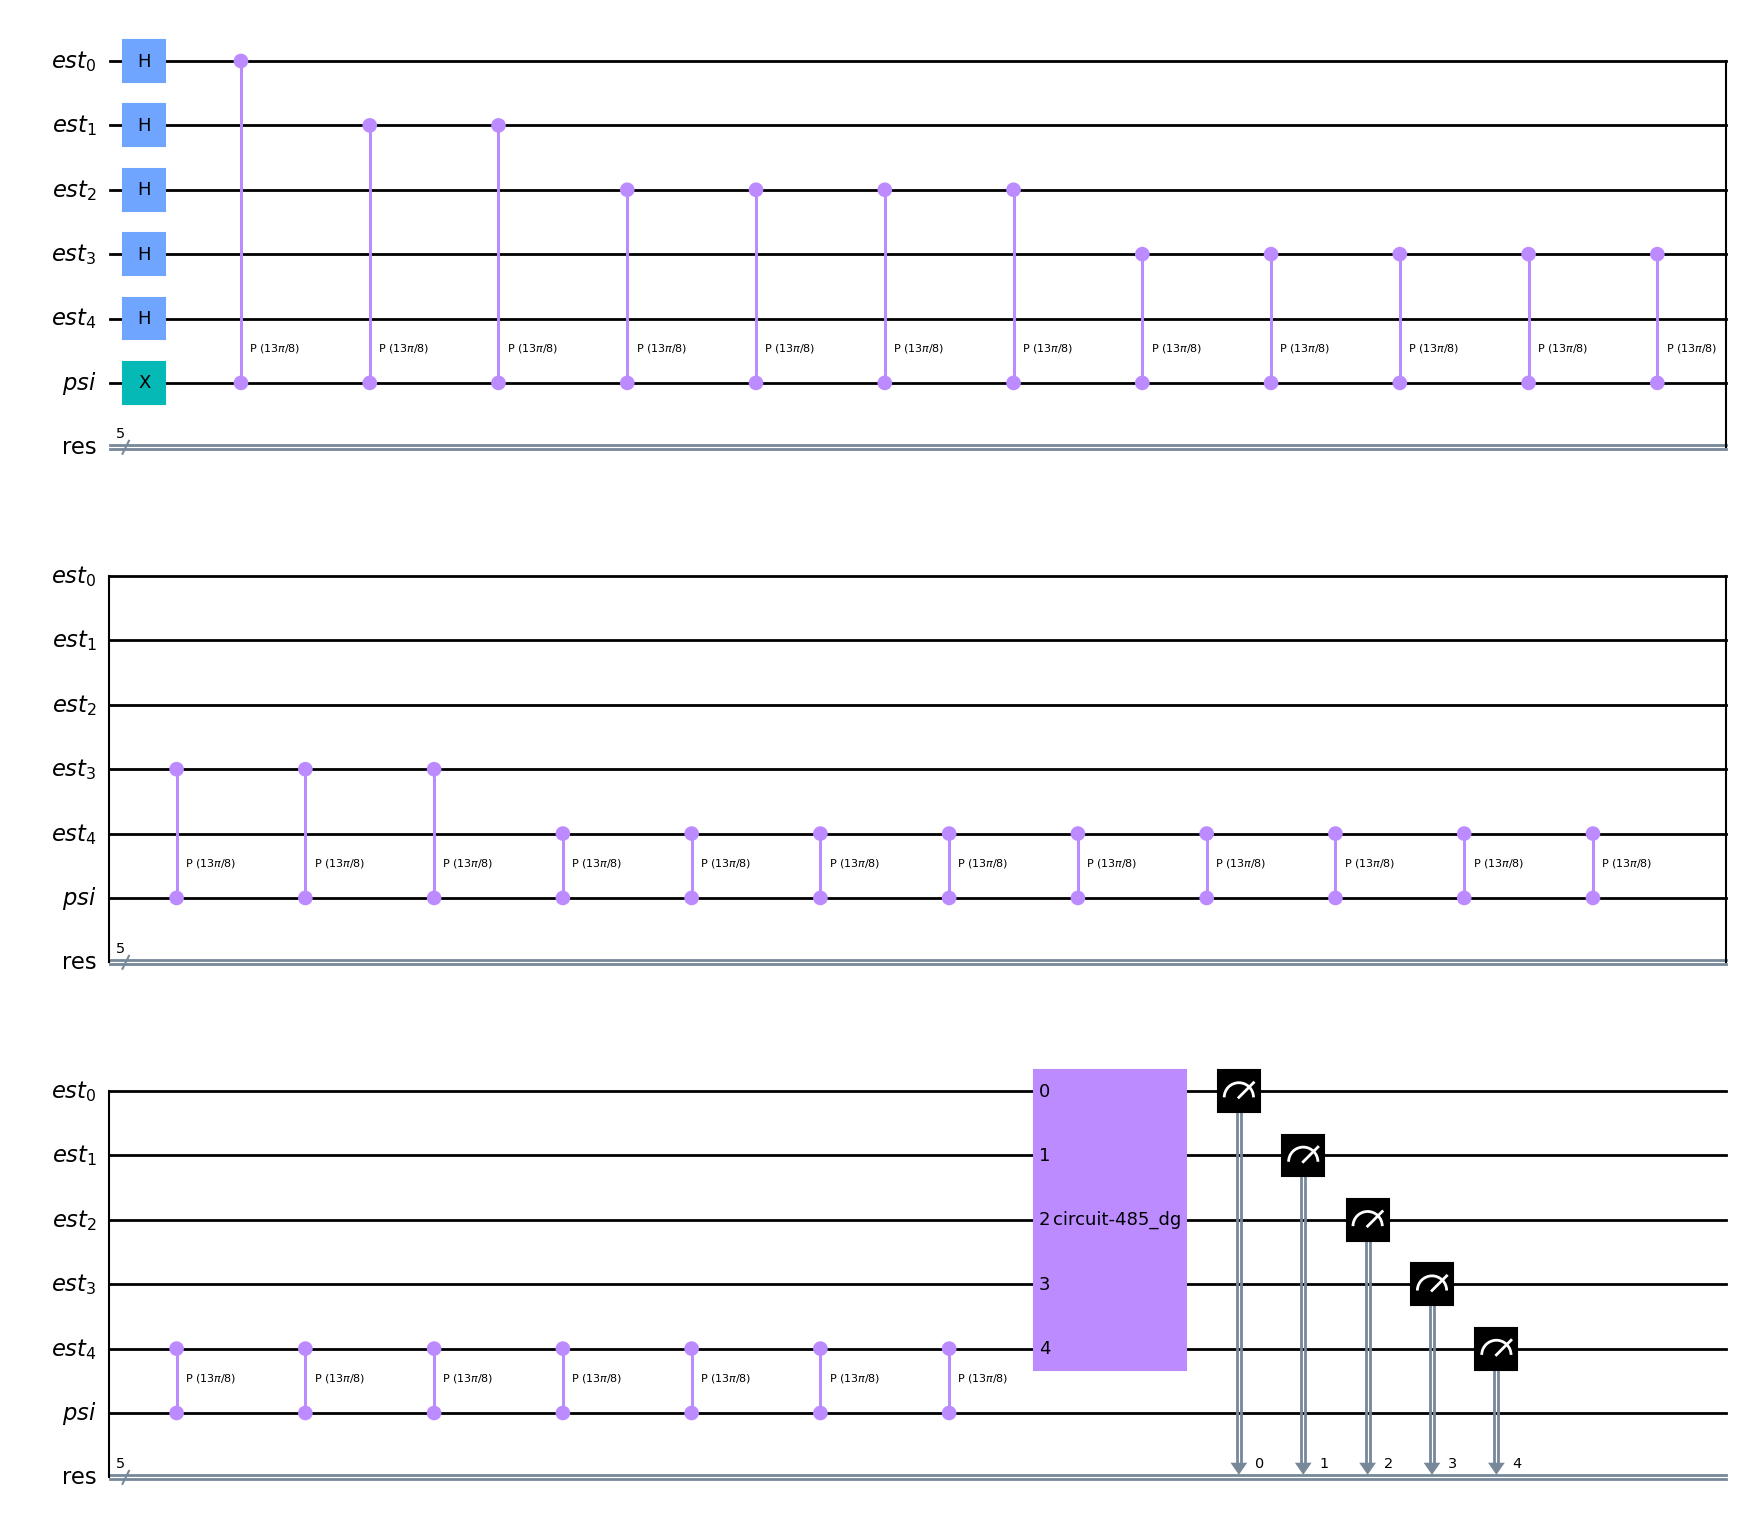

In [21]:
value = '11010' # Hacemos la regla para el número decimal binario 0.11010 = 13/16
qft = myqft(len(value))
qc = mtrule2(qft, value=value)
qc.draw(output='mpl')

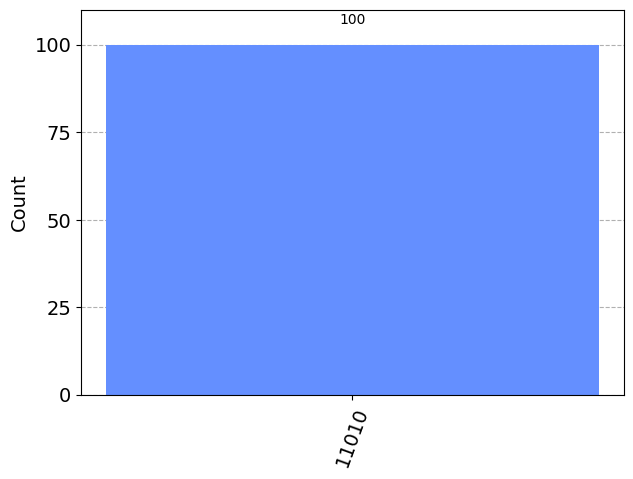

In [22]:
# The result is deterministic, in a perfect quantum computer we only need 1 shot

counts = execute(qc, QASM_BACK, shots=100).result().get_counts()
plot_histogram(counts)

In [13]:
mutant = myqft(len(value))
del mutant.data[1]
mutant.draw()

»
q_0: ─────────────────────────────────■───────────────────────■────────────────»
                                      │                       │                »
q_1: ───────────────■─────────────────┼─────────■─────────────┼────────■───────»
                    │                 │         │       ┌───┐ │        │P(π/2) »
q_2: ──────■────────┼────────■────────┼─────────┼───────┤ H ├─┼────────■───────»
     ┌───┐ │        │        │P(π/2)  │         │P(π/4) └───┘ │P(π/8)          »
q_3: ┤ H ├─┼────────┼────────■────────┼─────────■─────────────■────────────────»
     ├───┤ │P(π/4)  │P(π/8)           │P(π/16)                                 »
q_4: ┤ H ├─■────────■─────────────────■────────────────────────────────────────»
     └───┘                                                                     »
«                            ┌───┐   
«q_0: ─■─────────────■───────┤ H ├─X─
«      │       ┌───┐ │P(π/2) └───┘ │ 
«q_1: ─┼───────┤ H ├─■─────────X───┼─
«      │P(π/4) └───┘           │   │ 
«q_2: ─■───────────────────────┼───┼─
«                              │   │ 
«q_3: ─────────────────────────X───┼─
«                                  │ 
«q_4: ─────────────────────────────X─
«

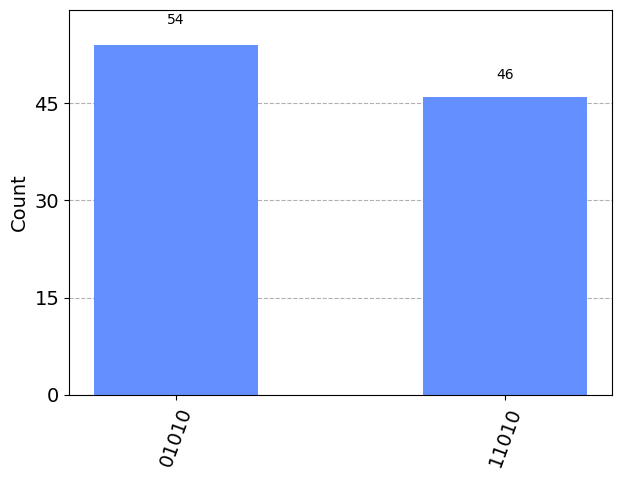

In [15]:
# En este caso no tenemos un resultado exacto. 

qc = mtrule2(mutant, value='11010')
counts = execute(qc, QASM_BACK, shots=100).result().get_counts()
plot_histogram(counts)

In [28]:
value = '110'
qft = myqft(len(value))
qc = mtrule2(qft, value='110')
backend = get_real_backend(3)
job = execute(qc, backend, shots=100)

In [31]:
qc.draw()

┌───┐                                                            »
est_0: ┤ H ├─■──────────────────────────────────────────────────────────»
       ├───┤ │                                                          »
est_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
       ├───┤ │         │         │                                      »
est_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
       ├───┤ │P(3π/2)  │P(3π/2)  │P(3π/2)  │P(3π/2)  │P(3π/2)  │P(3π/2) »
  psi: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
       └───┘                                                            »
res_0: ═════════════════════════════════════════════════════════════════»
                                                                        »
res_1: ═════════════════════════════════════════════════════════════════»
                                                                        »
res_2: ═════════════════════════════════════════════════════════════════»
                                                                        »
«                 ┌─────────────────┐┌─┐      
«est_0: ──────────┤0                ├┤M├──────
«                 │                 │└╥┘┌─┐   
«est_1: ──────────┤1 circuit-598_dg ├─╫─┤M├───
«                 │                 │ ║ └╥┘┌─┐
«est_2: ─■────────┤2                ├─╫──╫─┤M├
«        │P(3π/2) └─────────────────┘ ║  ║ └╥┘
«  psi: ─■────────────────────────────╫──╫──╫─
«                                     ║  ║  ║ 
«res_0: ══════════════════════════════╩══╬══╬═
«                                        ║  ║ 
«res_1: ═════════════════════════════════╩══╬═
«                                           ║ 
«res_2: ════════════════════════════════════╩═
«

In [32]:
job.queue_info()

<QueueInfo(job_id='6368e6c23f146d335eee7da6', _status='QUEUED', estimated_start_time='2022-11-07T12:26:57.724000+01:00', estimated_complete_time='2022-11-07T12:27:17.752000+01:00', position=38, hub_priority=1, group_priority=1, project_priority=1)>

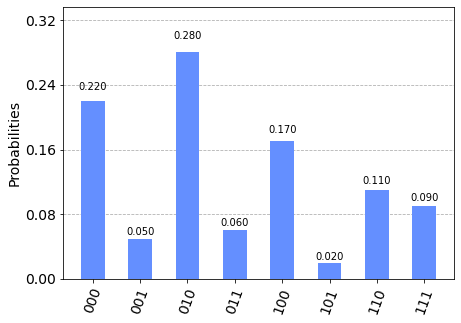

In [85]:
counts = job.result().get_counts()
plot_histogram(counts)

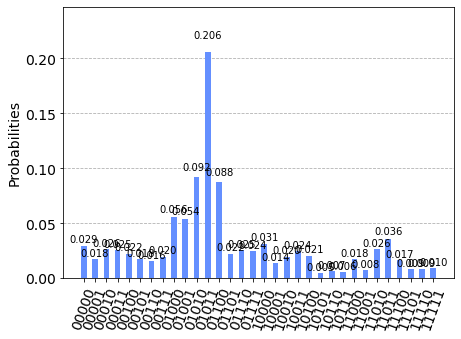

In [86]:
qc = mtrule2(value='01011')
counts = execute(qc, FakeGuadalupe()).result().get_counts()
plot_histogram(counts)

In [70]:
qc = mtrule2(value='1011')
counts = execute(qc, FakeManila(), counts=1000).result().get_counts()
plot_histogram(counts)

NameError: name 'FakeManila' is not defined

In [71]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.backend.ibmq_manila
job = execute(qc, backend, counts=1000)

/usr/local/lib/python3.8/dist-packages/qiskit/execute_function.py:399: UserWarning: counts is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


In [75]:
job.queue_info()

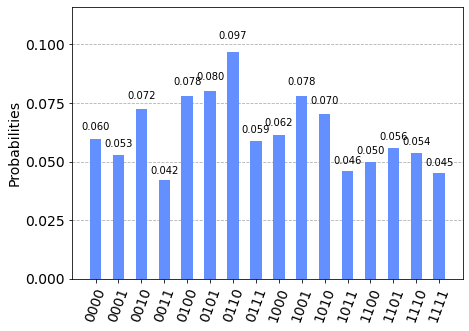

In [76]:
plot_histogram(job.result().get_counts())

In [ ]:
qc = mtrule2(value='10110')
counts = execute(qc, FakeMontreal(), counts=100).result().get_counts()
plot_histogram(counts)

In [43]:

from adder_mod import eq_gate, eq_circuit
eq = eq_circuit(3)
eq.draw()


┌──────────┐     ┌──────────────────┐     
anc_0: ─────┤0         ├─────┤0                 ├─────
       ┌───┐│          │     │                  │┌───┐
  b_0: ┤ X ├┤1         ├──■──┤1                 ├┤ X ├
       ├───┤│          │  │  │                  │├───┤
  b_1: ┤ X ├┤2         ├──■──┤2                 ├┤ X ├
       ├───┤│          │  │  │                  │├───┤
  b_2: ┤ X ├┤3  sum_i  ├──■──┤3 circuit-2258_dg ├┤ X ├
       └───┘│          │  │  │                  │└───┘
  a_0: ─────┤4         ├──┼──┤4                 ├─────
            │          │  │  │                  │     
  a_1: ─────┤5         ├──┼──┤5                 ├─────
            │          │  │  │                  │     
  a_2: ─────┤6         ├──┼──┤6                 ├─────
            └──────────┘┌─┴─┐└──────────────────┘     
res_0: ─────────────────┤ X ├─────────────────────────
                        └───┘

In [19]:
# This metamorphic rule is elegible for the Grover Algorithm
# It mimics the QPE for a given input value.


def mtrule3(qft, value='110'):
    nbits = len(value)
    qest = QuantumRegister(nbits, 'est')
    qinput = QuantumRegister(nbits, 'input')
    qanc = QuantumRegister(1, 'qanc')
    qres = QuantumRegister(1, 'qres')
    cres = ClassicalRegister(1, 'res')
    cinput = ClassicalRegister(nbits, 'cinput')
    cest = ClassicalRegister(nbits, 'cest')
    
    qc = QuantumCircuit(qanc, qres, qest, qinput, 
                        cres, cest) #, cinput)
    
    for i in range(nbits):
        if value[-i-1]=='1':
            qc.x(qinput[i])
    qc.h(qest)
    for i in range(nbits):
        power = 1
        for j in range(i, nbits):
            qc.cp(np.pi*power, qinput[j], qest[i])
            power = 0.5*power
    qc.append(qft.inverse(), qest[:])
    #qc.append(eq_gate(nbits), qanc[:]+qest[:]+qinput[::-1]+qres[:])
    
    
    qc.measure(qest[:], cest[:])
    return qc

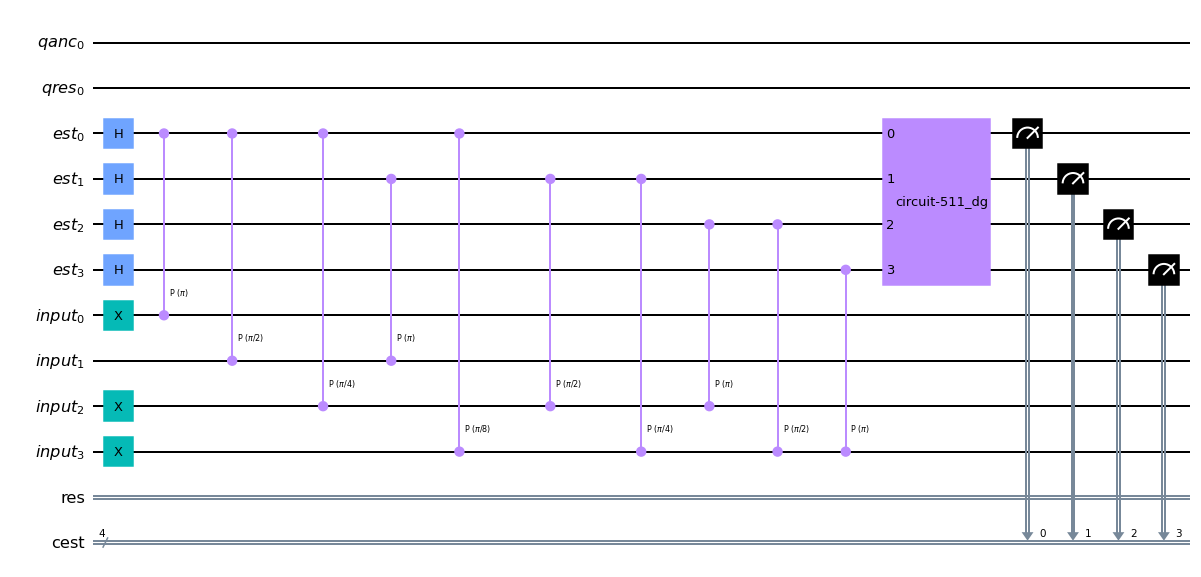

In [20]:
value = '1101'
nbits = len(value)
qft = myqft(nbits)
qc = mtrule3(qft, value)
qc.draw(output='mpl')

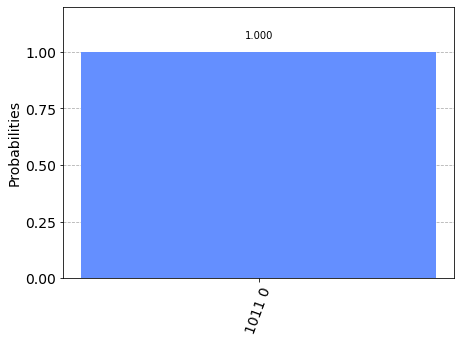

In [21]:
res = execute(qc, QASM_BACK, shots=100).result()
counts = res.get_counts()
plot_histogram(counts)

In [31]:
value = '1101'
nbits = len(value)
mutant = myqft(nbits)
print(mutant.draw())
del mutant.data[2]
print(mutant.draw(fold=-1))
qc = mtrule3(mutant, value)
counts = execute(qc, QASM_BACK, shots=100).result().get_counts()
print(counts)

                                                                          ┌───┐»
q_0: ─────────────────────────────■─────────────────■─────────────■───────┤ H ├»
                                  │                 │       ┌───┐ │P(π/2) └───┘»
q_1: ───────────────■─────────────┼────────■────────┼───────┤ H ├─■─────────X──»
                    │       ┌───┐ │        │P(π/2)  │P(π/4) └───┘           │  »
q_2: ──────■────────┼───────┤ H ├─┼────────■────────■───────────────────────X──»
     ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)                                      »
q_3: ┤ H ├─■────────■─────────────■────────────────────────────────────────────»
     └───┘                                                                     »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─┼─
«      │ 
«q_3: ─X─
«        
                                                                 ┌───┐   
q_0: ───────────────■──────────────────────■─────────────■───────┤ H ├─X─
                    │            

{'1': 1}


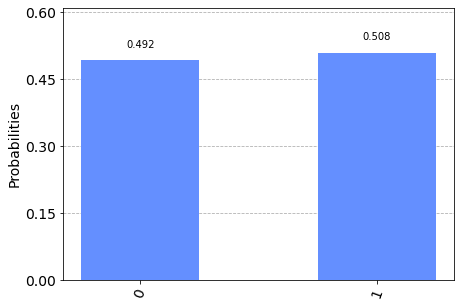

In [32]:
backend = FakeMontreal()
counts = execute(qc, backend, shots=1000).result().get_counts()
plot_histogram(counts)